In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.23.2
!pip install mne==0.24.0
!pip install mne_features==0.1

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? Y
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 6.8 MB 8.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
     |████████████████████████████████| 7.4 MB 4.2 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne

In [ ]:
from mne.datasets.sleep_physionet.age import fetch_data
from mne_features.feature_extraction import extract_features
from mne.time_frequency import psd_welch

In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [ ]:
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Feature Extraction For The First Person "Alice"

In [ ]:
ALICE = 1

[alice_files] = fetch_data(subjects=[ALICE], recording=[1])

mapping = {'rectal': 'misc',
           'marker': 'misc'}

raw_train = mne.io.read_raw_edf(alice_files[0])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
rectal, marker
Creating raw.info structure...


<RawEDF | SC4011E0-PSG.edf, 7 x 8406000 (84060.0 s), ~12 kB, data not loaded>

In [ ]:
set(raw_train.get_channel_types())
set(raw_train.annotations.description)
raw_train.get_data().shape[1]/raw_train.info['sfreq']/60/60
set(raw_train.ch_names)

{'Fpz-Cz', 'Pz-Oz', 'horizontal', 'marker', 'oro-nasal', 'rectal', 'submental'}

Effective window size : 20.480 (s)


<ipython-input-9-6f4001333b9e>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_train.plot_psd()


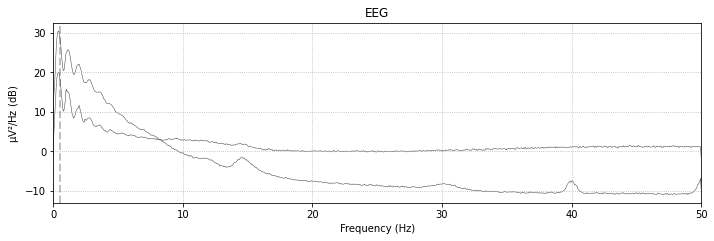

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


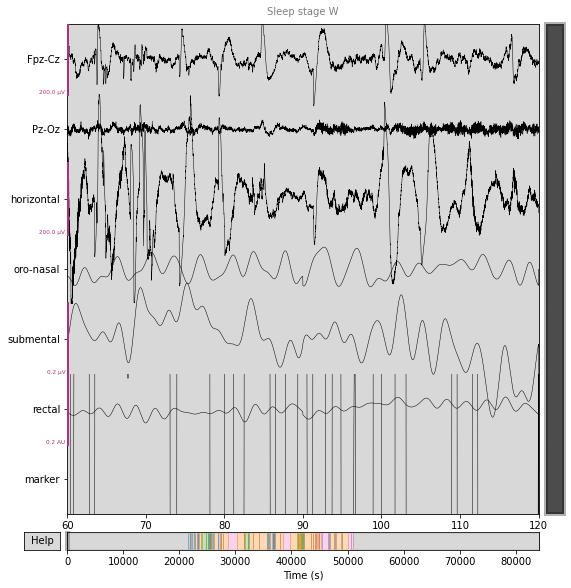

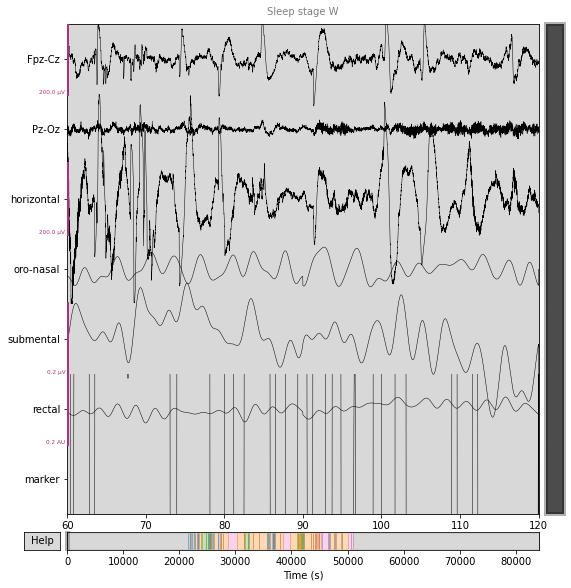

In [ ]:
raw_train.plot_psd()
# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


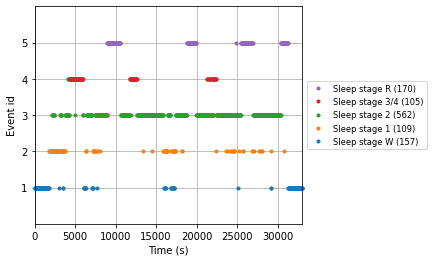

In [ ]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
tmax = 30. - 1. / raw_train.info['sfreq']
reject_criteria = dict(
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV
epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None, reject=reject_criteria)

print(epochs_train)


Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 157>


In [ ]:
epochs_train.get_data().shape

Loading data for 1103 events and 3000 original time points ...
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epo

(714, 7, 3000)

Sleep stage 1
Loading data for 68 events and 3000 original time points ...
Not setting metadata
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


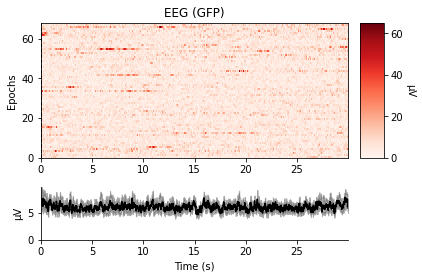

Sleep stage 2
Loading data for 493 events and 3000 original time points ...
Not setting metadata
Not setting metadata
493 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


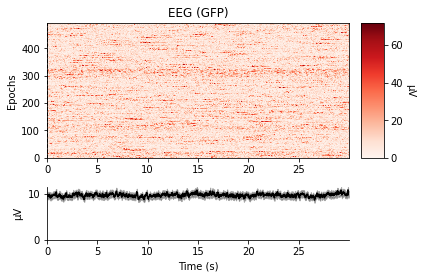

Sleep stage 3/4
Loading data for 48 events and 3000 original time points ...
Not setting metadata
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


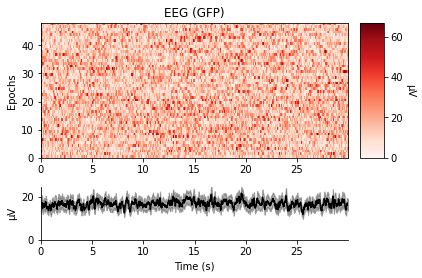

Sleep stage R
Loading data for 82 events and 3000 original time points ...
Not setting metadata
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


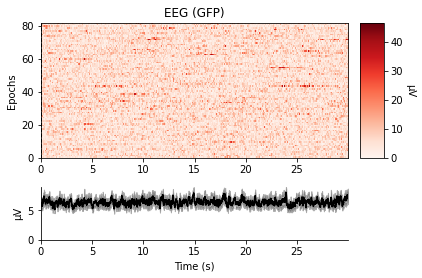

Sleep stage W
Loading data for 23 events and 3000 original time points ...
Not setting metadata
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


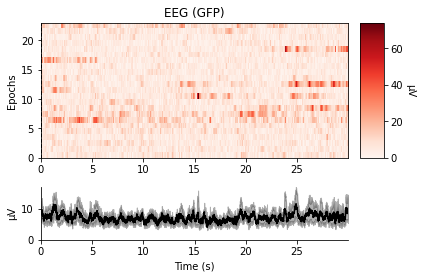

In [ ]:
# fig, ax = plt.subplots(ncols=1)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  epochs_train[stage].plot_image()

Loading data for 68 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 493 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 48 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 82 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 23 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


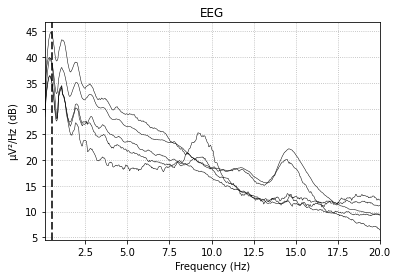

In [ ]:
fig, ax = plt.subplots(ncols=1)
stages = sorted(event_id.keys())  
for stage in stages:
      epochs_train[stage].plot_psd(area_mode=None, ax=ax,
                              fmin=0.1, fmax=20., show=False,
                              average=True, spatial_colors=False)

# Time Domain Features

In [ ]:
def plot_f_dist(feat):
  import seaborn as sns
  fig, (ax1,ax2) = plt.subplots(ncols=2)
  stages = sorted(event_id.keys())  
  for stage in stages:
    f = feat[y==event_id[stage]]
    sns.kdeplot(f[:,0], label = stage, ax=ax1)
    sns.kdeplot(f[:,1], label = stage, ax=ax2)
  # Plot formatting
  plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
  plt.title('Density Plot with Multiple Sleep Stages')
  plt.xlabel('V')
  plt.ylabel('Density')

In [ ]:
x = epochs_train.get_data()[:,:2,:]
y = epochs_train.events[:,2]

Loading data for 714 events and 3000 original time points ...


(714, 2)


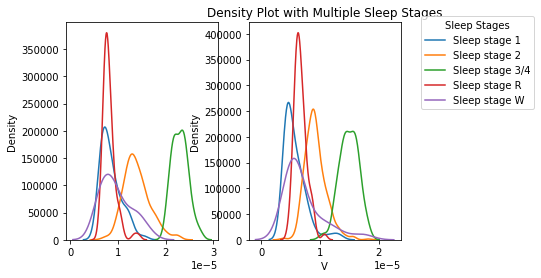

In [ ]:
f_std = x.std(axis=2)
print(f_std.shape)
plot_f_dist(f_std)

###Hjorth Parameters


1. **Hjorth Activity** represents the signal power, the variance of a time function. *(Calculated)*

2. **Hjorth Mobility** represents the mean frequency 

3. **Hjorth Complexity** represents the change in frequency. The parameter compares the signal's similarity to a pure sine wave

(714, 2)
(714, 2)


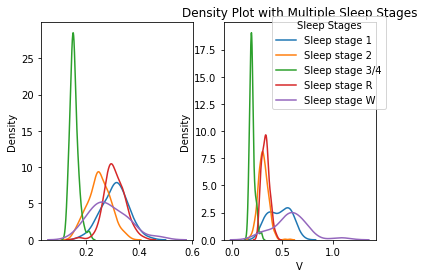

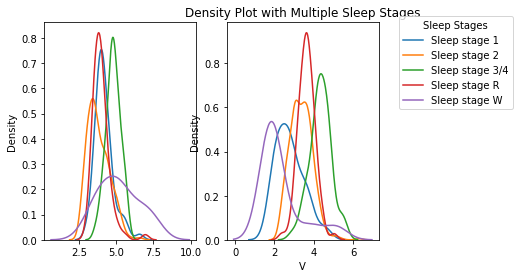

In [ ]:
selected_funcs = {'hjorth_mobility'}
f_hjorth_mobility = extract_features(x, raw_train.info['sfreq'], selected_funcs)
print(f_hjorth_mobility.shape)
plot_f_dist(f_hjorth_mobility)

selected_funcs = {'hjorth_complexity'}
f_hjorth_complexity = extract_features(x, raw_train.info['sfreq'], selected_funcs)
print(f_hjorth_complexity.shape)
plot_f_dist(f_hjorth_complexity)

###Entropy
It is used to measure uncertainty or randomness in the observed time-series

(714, 2)


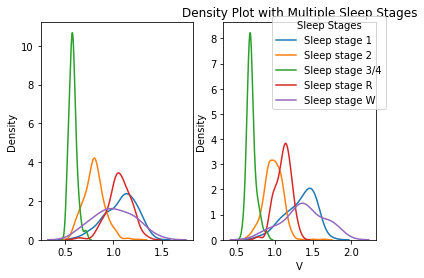

In [ ]:
selected_funcs = {'app_entropy'}
f_entropy = extract_features(x, raw_train.info['sfreq'], selected_funcs)
print(f_entropy.shape)
plot_f_dist(f_entropy)

#Frequency Domain Features



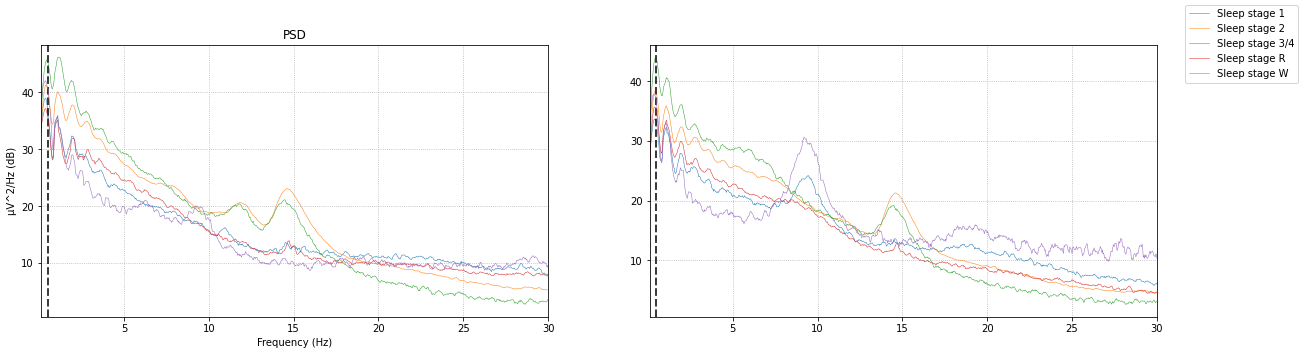

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
stages = sorted(event_id.keys())  
for stage, color in zip(stages, stage_colors):
      epochs_train[stage].plot_psd(area_mode=None, ax=ax1,  picks=['Fpz-Cz'], color=color,
                              fmin=0.1, fmax=30., show=False,
                              average=True, verbose=0)
      epochs_train[stage].plot_psd(area_mode=None, ax=ax2, picks=[ 'Pz-Oz'], color=color,
                              fmin=0.1, fmax=30., show=False,
                              average=True, verbose=0)
ax1.set(title='PSD', xlabel='Frequency (Hz)')
ax1.set(ylabel='µV^2/Hz (dB)')
fig.legend(ax1.lines[2::3], stages,)
plt.show()

In [ ]:
psds, freqs = psd_welch(epochs_train, picks='eeg', fmin=0.5, fmax=30.)
print(psds.shape)
print(freqs.max())

Loading data for 714 events and 3000 original time points ...
Effective window size : 2.560 (s)
(714, 2, 75)
29.6875


(714, 2)


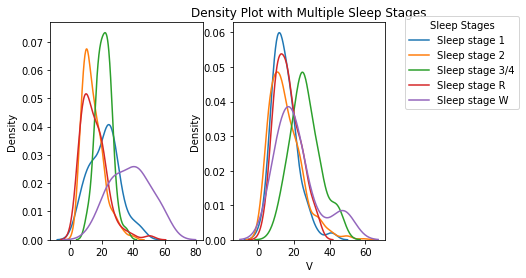

In [ ]:
psd_f_kurtosis = kurtosis(psds, axis=2)
print(psd_f_kurtosis.shape)
plot_f_dist(psd_f_kurtosis)

(714, 2)


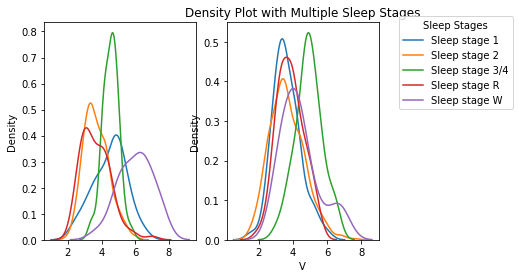

In [ ]:
f_psd_skewness = skew(psds, axis=2)
print(f_psd_skewness.shape)
plot_f_dist(f_psd_skewness)

###Entropy
But In The Frequency Domain

(714, 2)


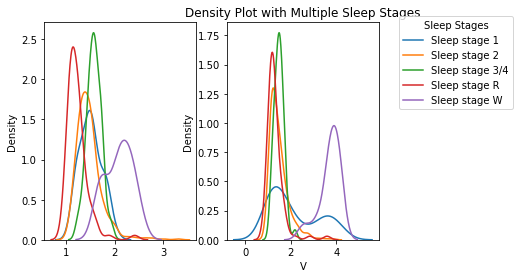

In [ ]:
selected_funcs = {'spect_entropy'}
f_psd_entropy = extract_features(psds, raw_train.info['sfreq'], selected_funcs)
print(f_psd_entropy.shape)
plot_f_dist(f_psd_entropy)

###Spectral Centroid
It is used to measure the center frequency of the spectrum

(714, 2)


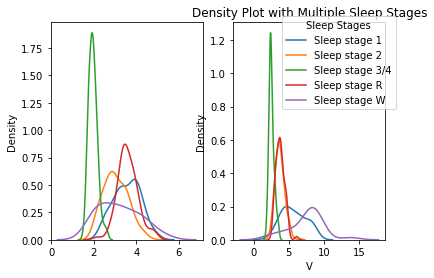

In [ ]:
f_psd_spectral_cent = (psds*freqs).sum(-1)/psds.sum(-1)
print(f_psd_spectral_cent.shape)
plot_f_dist(f_psd_spectral_cent)